In [15]:
from keras.models import Sequential, Model
from keras.layers import Dense, LSTM, Input
from keras.backend import clear_session
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

Plan

- RNN
- LSTM
- Attention mechanism
- Memory networks

Recurrent neural networks

The hidden state satisfies:
$$h(t) = \alpha(Wx(t) + Mh(t-1))$$

Where $x$ is the input.

BPTT (Backpropagation Through Time)

- extension of backprop
- trucated backprop (for numerical purposes, do not go until far away t)
- Vanishing and Exploding gradient problem: gradient go to zero or to infty

LSTM: solves the vanishing/exploding gradients. It adds cells where information it is choosen to be forgetted or kept. Gated recurrent units.

<h2>LSTM</h2>

In [27]:
#data input shape = (examples, timeseries_length, variables at time t used for prediction) -> value
#target shape = (examples) -> value
clear_session()

In [28]:
#model = Sequential()

In [29]:
#model.summary()

In [30]:
#history = model.fit(data_input,target,epochs=300,validation_data=(data_input,target))

In [31]:
#plt.plot(history.history['loss'])
#it does not work because data is not normalized, so gradients need to be too high

In [32]:
import keras.backend as K

n_input = 1
n_output = 1
n_units = 3

#ENCODER

encoder_input = Input(shape=(None, n_input))
encoder_lstm1 = LSTM(n_units, return_sequences=True, return_state=True)
encoder_lstm2 = LSTM(n_units, return_sequences=True, return_state=True)
encoder_dense = Dense(1, activation='linear')

encoder_output1, state_h1, state_c1 = encoder_lstm1(encoder_input)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)
encoder_output = encoder_output2 = encoder_dense(encoder_output2)

#DECODER

decoder_lstm1 = LSTM(n_units, return_sequences=True, return_state=True)
decoder_lstm2 = LSTM(n_units, return_sequences=True, return_state=True)
decoder_dense = Dense(1,activation='linear')

decoder_output1, state_h3, state_c3 = decoder_lstm1(encoder_output)
decoder_output2, state_h4, state_c4 = decoder_lstm2(decoder_output1)
output = decoder_dense(decoder_output2)

#encoder_output --> brownian to match via KL divergence
#state_c --> context to give to the decoder

model = Model([encoder_input], [output])


def custom_loss(layer):
    # Create a loss function that adds the MSE loss to the mean of all squared activations of a specific layer
    def loss(y_true,y_pred):
        bm = K.flatten(layer)
        mean = K.mean(bm)
        var = K.var(bm)
        KL_div = -0.5*K.log(var) + 0.5*var + 0.5*K.square(mean) - 0.5
        return K.mean(K.square(y_pred - y_true)) + KL_div
    # Return a function
    return loss

def custom_metric(layer):
    def metric(y_true,y_pred):
        bm = K.flatten(layer)
        mean = K.mean(bm)
        var = K.var(bm)
        KL_div = -0.5*K.log(var) + 0.5*var + 0.5*K.square(mean) - 0.5
        return KL_div
    # Return a function
    return metric

model.compile(optimizer='adam',
              loss=custom_loss(encoder_output),
              metrics=['accuracy',custom_metric(encoder_output)])

In [33]:
all_input = np.zeros(shape=(1000,100,1))
for i in range(1000):
    mean = 0.02*np.random.normal(0,1)
    vol = 0.2*np.random.random()
    data_input = np.cumsum(mean+vol*np.random.normal(0,1,100)).reshape((100,1))
    norm_input = (data_input-np.mean(data_input))/np.std(data_input)
    all_input[i] = norm_input
print(all_input.shape)

(1000, 100, 1)


In [42]:
history = model.fit(all_input,all_input,epochs=30,validation_data=(all_input,all_input))

Train on 1000 samples, validate on 1000 samples
Epoch 1/30
1000/1000 [==============================] - 5s 5ms/step - loss: 0.0961 - acc: 0.0000e+00 - metric: 0.0018 - val_loss: 0.0919 - val_acc: 0.0000e+00 - val_metric: 0.0016
Epoch 2/30
1000/1000 [==============================] - 5s 5ms/step - loss: 0.0888 - acc: 0.0000e+00 - metric: 0.0017 - val_loss: 0.0849 - val_acc: 0.0000e+00 - val_metric: 0.0015
Epoch 3/30
1000/1000 [==============================] - 5s 5ms/step - loss: 0.0819 - acc: 0.0000e+00 - metric: 0.0016 - val_loss: 0.0780 - val_acc: 0.0000e+00 - val_metric: 0.0013
Epoch 4/30
1000/1000 [==============================] - 5s 5ms/step - loss: 0.0754 - acc: 0.0000e+00 - metric: 0.0015 - val_loss: 0.0719 - val_acc: 0.0000e+00 - val_metric: 0.0012
Epoch 5/30
1000/1000 [==============================] - 5s 5ms/step - loss: 0.0695 - acc: 0.0000e+00 - metric: 0.0014 - val_loss: 0.0662 - val_acc: 0.0000e+00 - val_metric: 0.0010
Epoch 6/30
1000/1000 [==============================

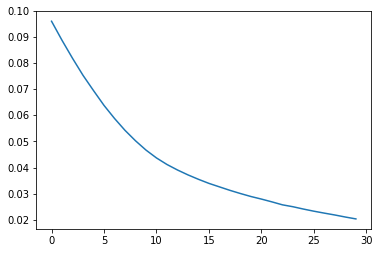

In [43]:
plt.plot(history.history['loss'])

In [48]:
mean = 0.02*np.random.normal(0,1)
vol = 0.2*np.random.random()
data_input = np.cumsum(mean+vol*np.random.normal(0,1,100)).reshape((100,1))

data_mean = np.mean(data_input)
data_std = np.std(data_input)
norm_data = (data_input-data_mean)/data_std

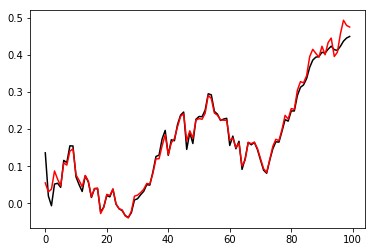

In [49]:
outp = model.predict(norm_data.reshape(1,-1,1)).reshape(-1)
plt.plot(outp*data_std+data_mean,'k')
plt.plot(data_input,'r')